# Computer Simulation Project
Simulating a discrete-event CPU scheduler.

**Authors**: <br>
Mohammadreza Mofayezi 98106059 <br>
Amirhossein Bagheri 98105621

## Import Libraries

In [239]:
from typing import List

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from queue import PriorityQueue

from scipy.stats import norm, expon, poisson

## Inputs
The parameters, number of processes and duration of simulation.

In [344]:
# parameters
X = 8
Y = 8
Z = 32
# number of processes
N = 100
# length of simulation
L = 800
# task threshold
K = 10
seed = 1234
T1 = 2
T2 = 4

In [241]:
np.random.seed(seed=seed)

## Job Creator

In [406]:
class Task:
    def __init__(self, id: int, X: int, Y: int, Z: int):
        self.id = id
        self.inter_arrival = int(poisson.rvs(X))
        self.service_time = int(expon.rvs(Y))
        self.time_out = int(expon.rvs(Z))
        self.remaining_service = self.service_time
        self.priority = self.get_priority()
        self.arrival_time = None
        self.finish = -1
        self.time_outed = False
        self.time_spent_in_queue = 0
        self.in_q = [-1 for _ in range(4)]
        self.out_q = [-1 for _ in range(4)]
        self.wait_time = [0 for _ in range(4)]

    def get_priority(self):
        return np.random.choice([1, 2, 3], 1, p=[0.1, 0.2, 0.7])[0]

    def __eq__(self, __o: object) -> bool:
        return self.priority == __o.priority

    def get_data(self):
        return [self.id, self.priority, self.inter_arrival, self.arrival_time, self.service_time, self.finish, self.finish - self.arrival_time, self.finish - self.arrival_time - self.service_time, self.time_out, self.time_outed]

    def __repr__(self) -> str:
        return f'Task {self.id} Priority: {self.priority} - InterArrival: {self.inter_arrival} - Arrival: {self.arrival_time} - ServiceTime: {self.service_time} FinishTime: {self.finish} SystemTime: {self.finish - self.arrival_time} WaitingTime: {self.finish - self.arrival_time - self.service_time} TimeOut: {self.time_out} TimeOuted: {self.time_outed}'


class JobCreator:
    def __init__(self, num_tasks: int):
        self.num_tasks = num_tasks
        self.tasks = PriorityQueue()
        self.all_tasks = []

    def run(self, X: int, Y: int, Z: int):
        start = 0
        task = Task(0, X, Y, Z)
        task.arrival_time = 0
        self.tasks.put((task.arrival_time, task.priority, -
                       task.remaining_service, task))
        self.all_tasks.append(task)

        for i in range(1, self.num_tasks):
            task = Task(i, X, Y, Z)
            start += task.inter_arrival
            task.arrival_time = start
            self.tasks.put((task.arrival_time, task.priority, -
                           task.remaining_service, task))
            self.all_tasks.append(task)

    def get_task(self, time: int):
        if self.tasks.queue[0][0] <= time:
            return self.tasks.get()[-1]
        return None

    def len(self):
        return len(self.tasks.queue)

    def len_arrived(self, time: int):
        return sum(1 for t in self.tasks.queue if t[-1].arrival_time <= time)

    def empty_job(self):
        return self.tasks.empty()


## Queues
First Come First Serve and Round Robin Queue.

In [324]:
class FCFS:
    def __init__(self):
        self.q = []

    def insert(self, task: Task):
        self.q.insert(0, task)

    def len(self):
        return len(self.q)

    def run(self):
        q = []
        for i in range(len(self.q)):
            if self.q[i].remaining_service > 0:
                q.append(self.q[i])
        self.q = q

    def get_task(self):
        return self.q[-1]

    def pop_task(self):
        return self.q.pop()

    def give_up(self, task: Task = None):
        return False

    def runtime(self):
        return float("inf")


class RR(FCFS):
    def __init__(self, T: int):
        super().__init__()
        self.T = T

    def give_up(self, task: Task = None):
        """Determines whether task should be passed to the next queue."""
        # return task.remaining_service > self.T
        return task.time_spent_in_queue == self.T and task.remaining_service > 0

    def runtime(self):
        """The quantum time of round robin queue"""
        return self.T


## Processor

In [409]:
class Processor:
    def __init__(self, num_tasks: int, max_simulation: int, queues: List, P: List, K: int, X: int, Y: int, Z: int, exp_name='default'):
        self.num_tasks = num_tasks
        self.job_creator = JobCreator(num_tasks)
        self.job_creator.run(X, Y, Z)
        self.queues = queues
        self.simulation_time = 0
        self.idle_time = 0
        self.max_simulation_time = max_simulation
        self.K = K
        self.order_of_finish = []
        self.P = P
        self.queue_lens_time = []
        self.queue_lens = [[] for _ in range(len(queues) + 1)]
        self.exp_name = exp_name

    def job_loader(self, k: int):
        if sum([q.len() for q in self.queues]) >= k:
            return
        queue = PriorityQueue()
        for _ in range(k):
            if self.job_creator.empty_job():
                break
            task = self.job_creator.get_task(self.simulation_time)
            if task is None:
                break
            task.in_q[-1] = task.arrival_time
            task.out_q[-1] = self.simulation_time
            queue.put((task.priority, -task.remaining_service, task))

        for _ in range(len(queue.queue)):
            task = queue.get()[-1]
            task.in_q[0] = self.simulation_time
            self.queues[0].insert(task)

    def process(self, i: int):
        self.set_queue_lens()
        q = self.queues[i]
        task = q.get_task()
        # time = min(q.runtime(), task.remaining_service)
        time = 1
        task.time_spent_in_queue += time
        task.remaining_service = task.remaining_service - time
        give_up = q.give_up(task)
        self.simulation_time += time
        if task.remaining_service == 0:
            self.order_of_finish.append(task)
            task.finish = self.simulation_time
            task.out_q[i] = self.simulation_time
            task.wait_time[i] = task.out_q[i] - task.in_q[i] - (task.service_time - self.queues[0].runtime() - self.queues[1].runtime())
            q.pop_task()
        # q.run()
        if give_up:
            task.time_spent_in_queue = 0
            task = q.pop_task()
            task.out_q[i] = self.simulation_time
            task.wait_time[i] = task.out_q[i] - task.in_q[i] - self.queues[i].runtime()
            task.in_q[i + 1] = self.simulation_time
            self.queues[i + 1].insert(task)
        self.queue_lens[-1].append(self.job_creator.len_arrived(self.simulation_time))
        self.job_loader(self.K)

    def queue_chooser(self):
        return np.random.choice(list(range(len(self.P))), 1, p=self.P)[0]

    def time_out(self):
        for q_i, q in enumerate(self.queues):
            qq = []
            for i in range(q.len()):
                if self.simulation_time - q.q[i].arrival_time > q.q[i].time_out:
                    q.q[i].finish = self.simulation_time
                    q.q[i].time_outed = True
                    q.q[i].out_q[q_i] = self.simulation_time
                    q.q[i].wait_time[q_i] = q.q[i].out_q[q_i] - q.q[i].in_q[q_i] - \
                                            self.queues[q_i].T if isinstance(self.queues[q_i], RR) else \
                                            (q.q[i].service_time - self.queues[0].runtime() - self.queues[1].runtime() - q.q[i].remaining_service)
                    self.order_of_finish.append(q.q[i])
                else:
                    qq.append(q.q[i])
            q.q = qq

    def dispatcher(self):
        while (self.job_creator.len() > 0 or sum([q.len() for q in self.queues]) > 0) and self.simulation_time <= self.max_simulation_time:
            if sum([q.len() for q in self.queues]) > 0:
                choose = self.queue_chooser()
                if self.queues[choose].len() > 0:
                    self.process(choose)
            else:
                self.set_queue_lens()
                self.queue_lens[-1].append(self.job_creator.len_arrived(self.simulation_time))
                self.simulation_time += 1
                self.idle_time += 1
                self.job_loader(self.K)
            self.time_out()

    def set_queue_lens(self):
        for i in range(len(self.queues)):
            self.queue_lens[i].append(self.queues[i].len())
        self.queue_lens_time.append(self.simulation_time)

    def run(self, verbose=False):
            self.job_loader(self.K)
        self.dispatcher()
        if verbose:
            print(f"Number of jobs done: {len(self.order_of_finish)}")
            for task in self.order_of_finish:
                print(task)

    def save_csv(self):
        df = pd.DataFrame(columns=['Task',
                                   'Priority',
                                   'InterArrival',
                                   'Arrival',
                                   'ServiceTime',
                                   'FinishTime',
                                   'SystemTime',
                                   'WaitingTime',
                                   'TimeOut',
                                   'TimeOuted']
                          )
        for task in self.order_of_finish:
            row = pd.Series(task.get_data(), index=df.columns)
            df = df.append(row, ignore_index=True)

        df.to_csv(f'results-{self.exp_name}.csv')

    def num_tasks_done(self):
        return sum(1 for task in processor.order_of_finish if task.time_outed == False)

    def get_task_in_q_time(self):
        task_in_q_time = [[0 for _ in range(self.num_tasks)] for _ in range(4)]
        for task in self.order_of_finish:
            for i in range(4):
                task_in_q_time[i][task.id] = task.out_q[i] - task.in_q[i]
        return task_in_q_time


In [366]:
np.random.seed(seed=11)
processor = Processor(N, L, [RR(T1), RR(T2), FCFS()], [0.8, 0.1, 0.1], K=K, X=X, Y=Y, Z=Z)
processor.run(verbose=False)
# processor.save_csv()


801


## Results

In [377]:
inputs = [{'X': 8, 'Y': 8, 'Z': 32, 'N': 100, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 4, 'Z': 32, 'N': 50, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 6, 'Z': 16, 'N': 100, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 8, 'Z': 32, 'N': 100, 'L': 800, 'K': 10, 'T1': 6, 'T2': 8}]


In [356]:
queue_names = ['Round-Robin-T1', 'Round-Robin-T2', 'FCFS', 'Priority Queue']


def get_input_name(inp):
    return str(inp)[1:-1].replace("'", "").replace(": ", "-").replace(", ", "-")


def run(input_i, save=False):
    exp_name = get_input_name(input_i)
    print(f'Running {exp_name}')
    np.random.seed(seed=seed)
    processor = Processor(input_i['N'], input_i['L'], [RR(input_i['T1']), RR(input_i['T2']), FCFS()], [0.8, 0.1, 0.1],
                          K=input_i['K'], X=input_i['X'], Y=input_i['Y'], Z=input_i['Z'], exp_name=exp_name)
    processor.run(verbose=False)
    # print(f"Number of jobs done: {len(processor.order_of_finish)}")
    if save:
        processor.save_csv()
    return processor


def run_and_plot(input_i, plot_func, save=False):
    processor = run(input_i, save)
    plot_func(processor, save, processor.exp_name)


### Length of Queues

In [462]:
def plot_queue_lens(processor, save=False, input_name='default'):
    fig, ax = plt.subplots()
    for i in range(4):
        print(f'Average of length {queue_names[i]}: {np.mean(processor.queue_lens[i]):.2f}')
        ax.plot(processor.queue_lens_time, processor.queue_lens[i], label=queue_names[i])
    ax.legend()
    ax.set_yticks([i for i in range(np.max(processor.queue_lens) + 1)])
    ax.set_title('Length of queues during simulation time')
    plt.show()
    if save:
        fig.savefig(f'figs/loq/queue-len-{input_name}.png')


Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.30
Average of length Round-Robin-T2: 2.03
Average of length FCFS: 0.87
Average of length Priority Queue: 0.12


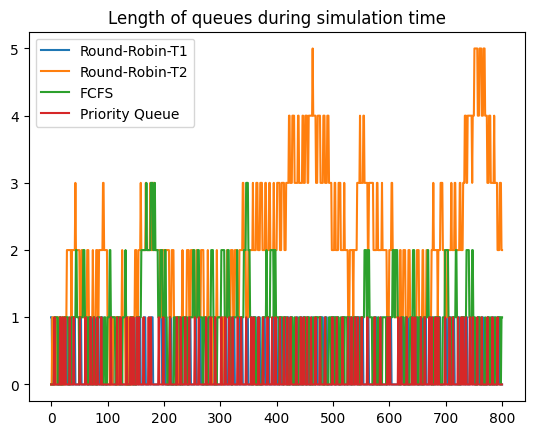

Running X-8-Y-4-Z-32-N-50-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.25
Average of length Round-Robin-T2: 0.33
Average of length FCFS: 0.02
Average of length Priority Queue: 0.02


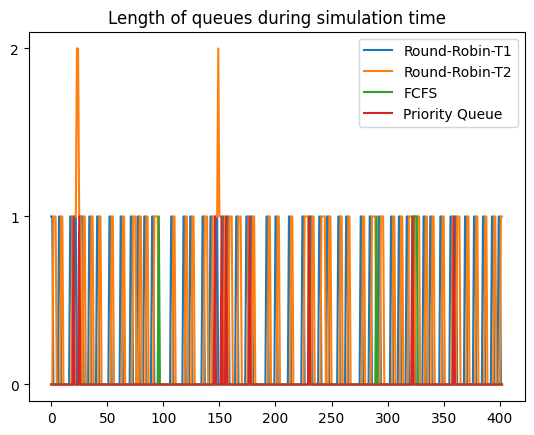

Running X-8-Y-6-Z-16-N-100-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.26
Average of length Round-Robin-T2: 0.67
Average of length FCFS: 0.13
Average of length Priority Queue: 0.06


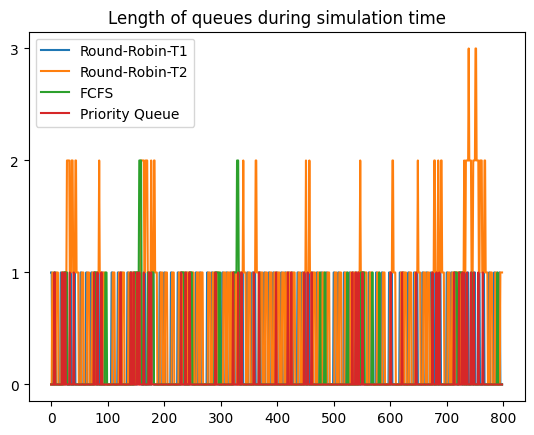

Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-6-T2-8
Average of length Round-Robin-T1: 0.98
Average of length Round-Robin-T2: 2.23
Average of length FCFS: 0.00
Average of length Priority Queue: 0.12


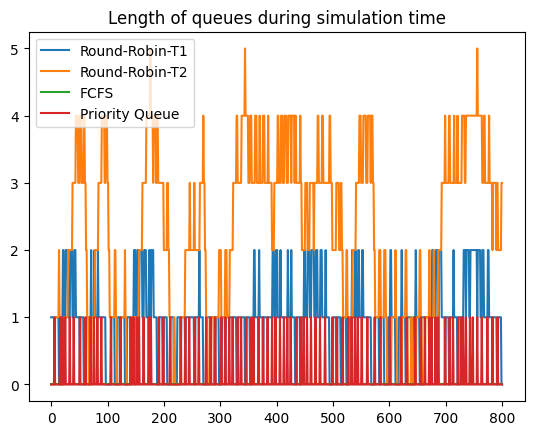

In [463]:
for i in inputs:
    run_and_plot(i, plot_queue_lens, save=True)

### Time Spent in Queues

In [464]:
def plot_queue_lens(processor, save=False, input_name='default'):
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(30)
    task_in_q_time = processor.get_task_in_q_time()
    task_indices = np.arange(len(task_in_q_time[0]))
    for i in range(4):
        print(f'Average waiting time in {queue_names[i]} is {np.mean(task_in_q_time[i]):.2f}')
        ax.stem(task_indices, task_in_q_time[i], linefmt='grey', markerfmt='D', label=queue_names[i])
    average_wait = np.mean(np.array(task_in_q_time), axis=0)
    print(f'Average waiting time in all queues is {np.mean(average_wait):.2f}')
    ax.plot(average_wait, label='Average')
    ax.legend()
    ax.set_xticks(task_indices)
    ax.set_title('Waiting time in queue per task')
    plt.show()
    if save:
        fig.savefig(f'figs/tsq/task-in-queue-{input_name}.png')


Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-2-T2-4
Average waiting time in Round-Robin-T1 is 2.32
Average waiting time in Round-Robin-T2 is 15.82
Average waiting time in FCFS is 6.91
Average waiting time in Priority Queue is 0.00
Average waiting time in all queues is 6.26


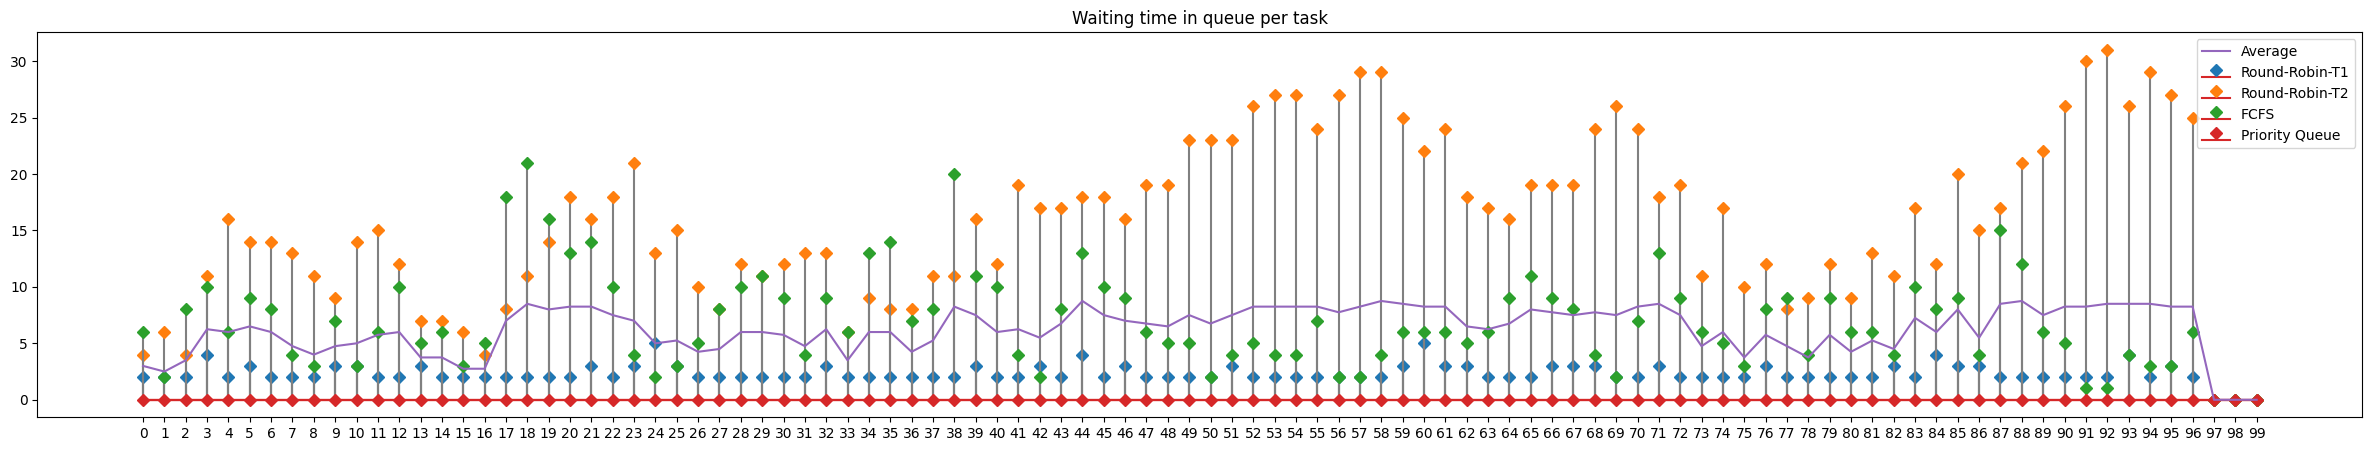

Running X-8-Y-4-Z-32-N-50-L-800-K-10-T1-2-T2-4
Average waiting time in Round-Robin-T1 is 2.02
Average waiting time in Round-Robin-T2 is 2.62
Average waiting time in FCFS is 0.14
Average waiting time in Priority Queue is 0.00
Average waiting time in all queues is 1.20


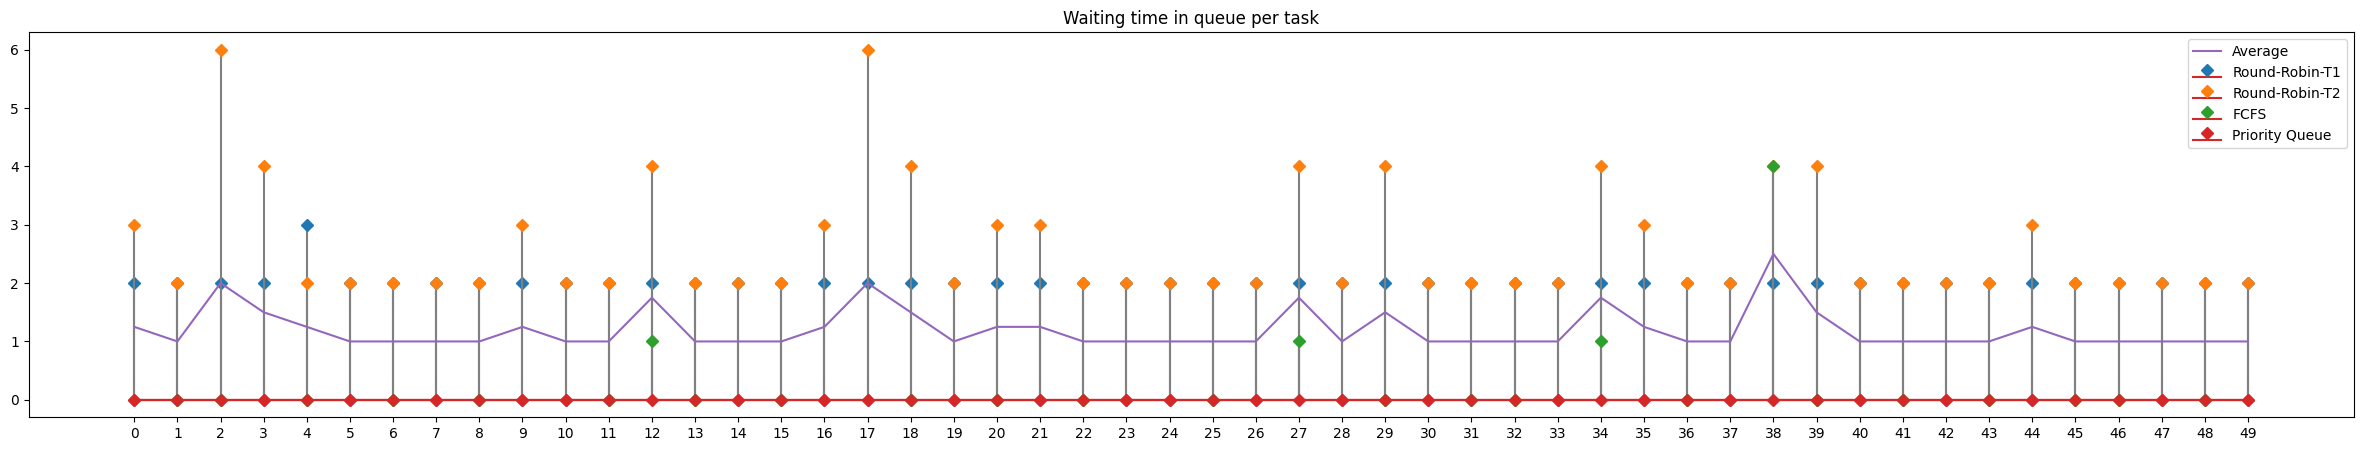

Running X-8-Y-6-Z-16-N-100-L-800-K-10-T1-2-T2-4
Average waiting time in Round-Robin-T1 is 2.11
Average waiting time in Round-Robin-T2 is 5.36
Average waiting time in FCFS is 1.00
Average waiting time in Priority Queue is 0.00
Average waiting time in all queues is 2.12


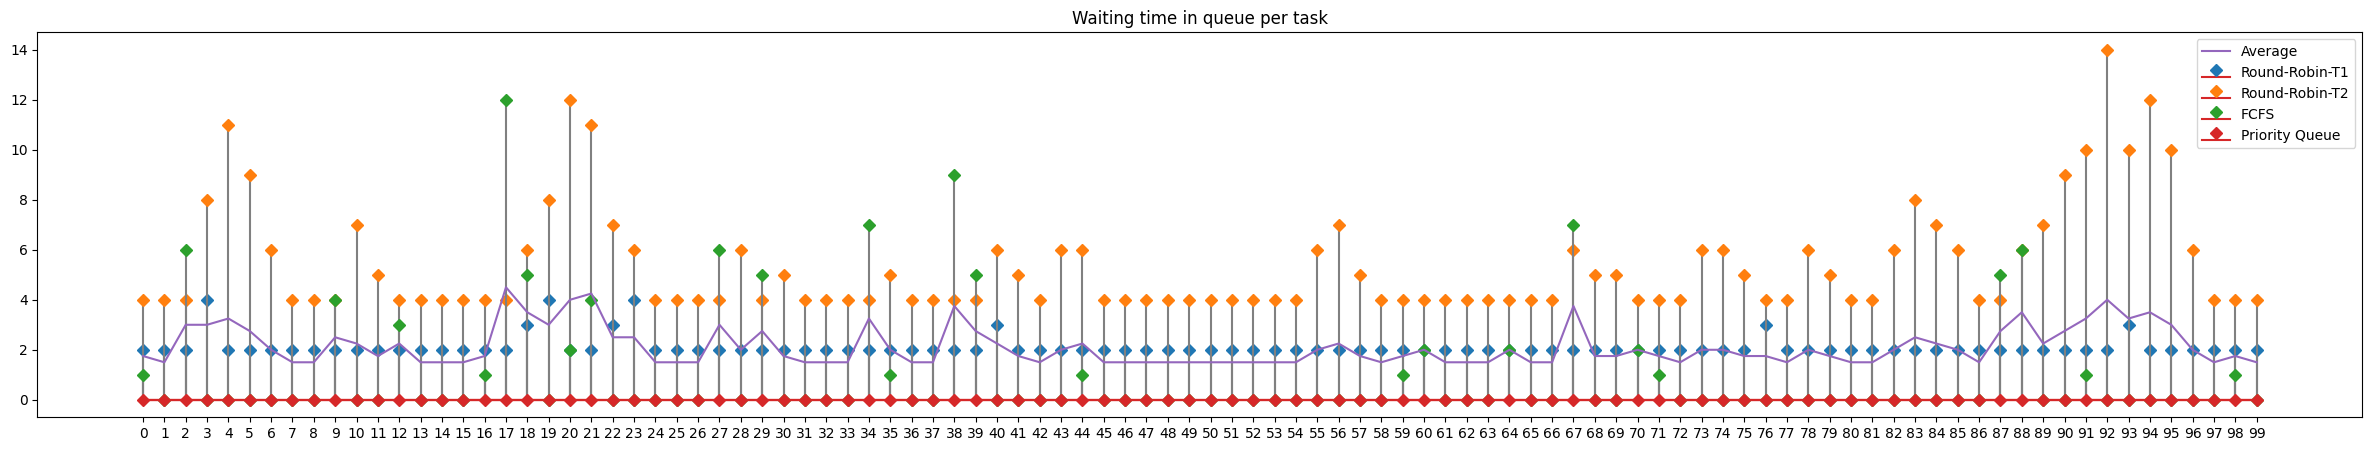

Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-6-T2-8
Average waiting time in Round-Robin-T1 is 7.72
Average waiting time in Round-Robin-T2 is 17.73
Average waiting time in FCFS is 0.00
Average waiting time in Priority Queue is 0.00
Average waiting time in all queues is 6.36


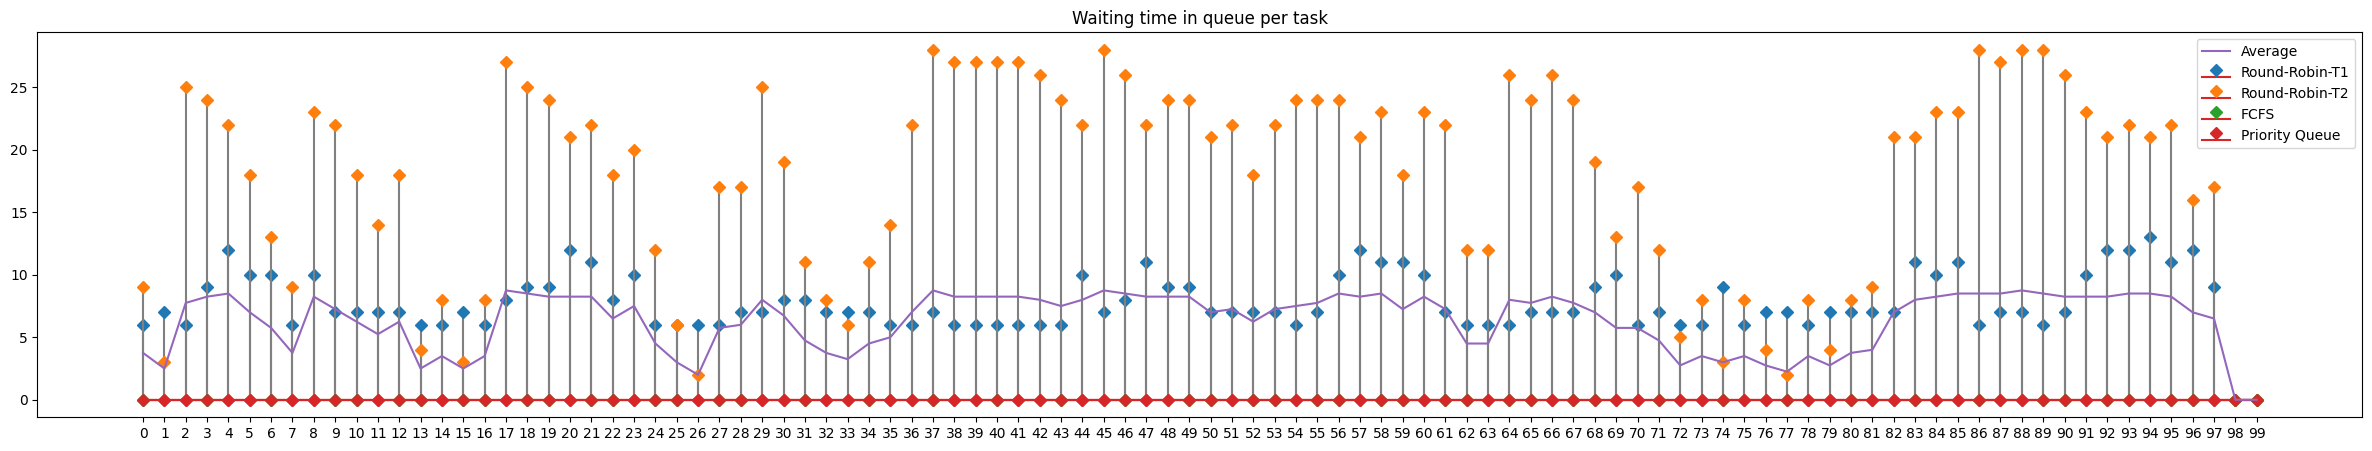

In [465]:
for i in inputs:
    run_and_plot(i, plot_queue_lens, save=True)

### CPU Utilization

In [382]:
for i in inputs:
    processor = run(i)
    processor.save_csv()
    utilization = (i['L'] - processor.idle_time) / i['L']
    print(f'Server Utilization: {utilization * 100:.1f}%')

Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-2-T2-4
Server Utilization: 100.0%
Running X-8-Y-4-Z-32-N-50-L-800-K-10-T1-2-T2-4
Server Utilization: 78.0%
Running X-8-Y-6-Z-16-N-100-L-800-K-10-T1-2-T2-4
Server Utilization: 80.2%
Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-6-T2-8
Server Utilization: 98.5%


### Expired Tasks

In [380]:
for i in inputs:
    processor = run(i)
    num_expired = sum(1 for task in processor.order_of_finish if task.time_outed == True)
    expire_rate = num_expired / i['N']
    print(f'{num_expired} tasks expired: {expire_rate * 100:.1f}%')

Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-2-T2-4
20 tasks expired: 20.0%
Running X-8-Y-4-Z-32-N-50-L-800-K-10-T1-2-T2-4
0 tasks expired: 0.0%
Running X-8-Y-6-Z-16-N-100-L-800-K-10-T1-2-T2-4
1 tasks expired: 1.0%
Running X-8-Y-8-Z-32-N-100-L-800-K-10-T1-6-T2-8
28 tasks expired: 28.0%
